# This project is focused on us building a model to predict housing prices. 

The data set is from kaggle. 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

My analysis will create a somewhat predicitve linear regression model. I used various modeling tools and techniques coming mostly from Prof Folkmans lesson on linear regression. This includes my final model, using elastic net.
https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_4_Linear_Regression_and_Evaluation.ipynb

I gained most of my insight for cleaining the data from a kernel by Serigne attached to the project
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

I learned how to test my model and submit it to kaggle from this kernel by Dan
https://www.kaggle.com/dansbecker/submitting-from-a-kernel



# Import essential packages

In [1136]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew #for some statistics

#TOOLS FOR SCALING DATA

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Polynomial regression
from sklearn.preprocessing import PolynomialFeatures

#lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#testing confidence intervals
from sklearn.utils import resample

#train test split
from sklearn.model_selection import train_test_split

# Import and understand the data set

In [1137]:
training = pd.read_csv("/Users/tclawson/Desktop/HW2/train.csv")

In [1138]:
#I want to get a look for what is in the data set, this gives the first 5 data points
training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


my first thought after seeing this is all of the categorical and Na values, we'll have to do quite a bit of cleaning before we can run a model

In [1139]:
#I want to know what every column(variable) is, 
#I can reference the data.txt file to learn more about each of them
training.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Cleaning data

In [1140]:
#From the head, we can see ID is clearly not helpful it is a label that doesnt add any value or insight, 
#lets first sav it, then drop it from the dataframe
train_ID = training['Id']




In [1141]:
training.drop("Id", axis = 1, inplace = True)


In [1142]:
#we will be looking at a few scatter plots so I create a function
def scatter(file):
    fig, ax = plt.subplots()
    ax.scatter(x = file['GrLivArea'], y = file['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel('GrLivArea', fontsize=13)
    plt.show()

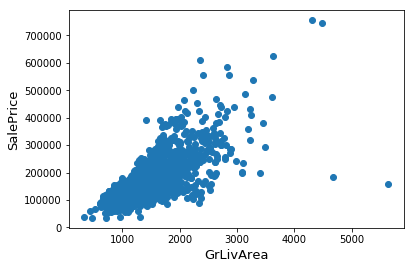

In [1143]:
#lets look at one of the biggest correlations possible, living area sq footage 
#and price to see if there are any outliers
scatter(training)

This is a great find from the scatter plot, we ned to drop those two variables on the bottom right of the set

In [1144]:
#here we can emiinate those extraneous points on the bottom right, 
#they are massive sq footage with low costs which would skew our results
training = training.drop(training[(training['GrLivArea']>4000) & (training['SalePrice']<300000)].index)

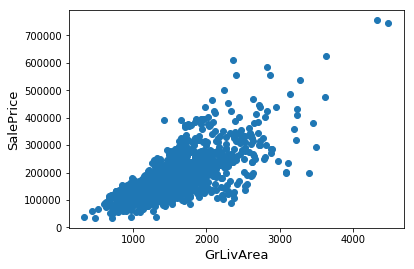

In [1145]:
scatter(training)
#this gives us the hopefully cleaned data

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


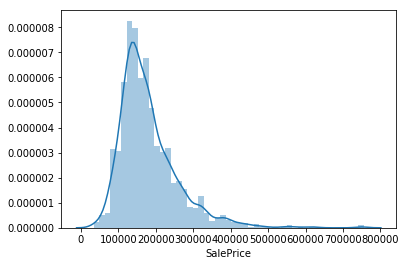

In [1146]:
#lets dive into our target variable SalePrice by taking a look at the distribution
sns.distplot(training['SalePrice'], kde=True)

This shows us the data is not distrubted normally and we need normally distrubuted data to work with linear regression. so lets normalize, we'll start by making a new data frame with the SalePrice variable

In [1147]:
#lets create an isolated data frame for our target variable, called target
target = training['SalePrice']

In [1148]:
#here we normalize the data with a log function
target = np.log(target)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


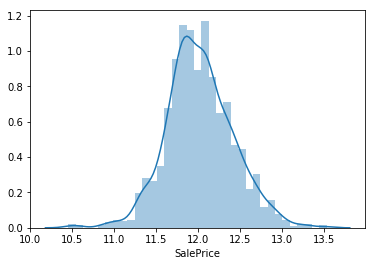

In [1149]:
#If we have isolted and normalized the data we should see a normal distribution below
sns.distplot(target, kde=True)

Great! Normally distributed data, now lets remove that from our original data set so we can make predictions without biasing to the known sales price

In [1150]:
#now that we've isolated it, lets remove the SalePrice column

training = training.drop(['SalePrice'], axis=1)
#axis=1 in python represents a column

With this we now have a training data set with the key variables we want, there are a lot of Na and empty variables, lets try to fill in those numbers

In [1151]:
#given my quick scans of the sumary stats and head data, we have a lot of missing vlaues, 
#lets create a data set built around the nul vavlues to see how much data is missing

training_na = (training.isnull().sum() / len(training)) * 100
training_na = training_na.drop(training_na[training_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :training_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageYrBlt,5.555556
GarageType,5.555556
GarageFinish,5.555556
GarageQual,5.555556


Text(0.5,1,'Percent missing data by feature')

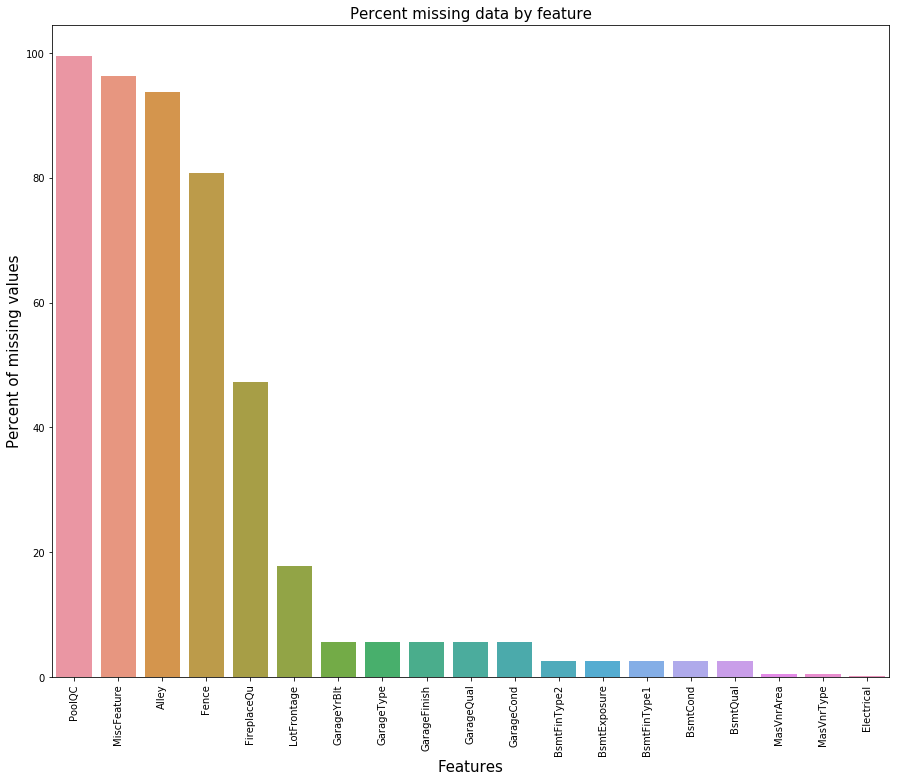

In [1152]:
#this will visualize the missing variables that we will then be able to fill in.

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=training_na.index, y=training_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Before we clean the entire set, lets merge data sets
## Given the quantity of missing data in the training set we will need to assume a lot of values in the set, lets combine the test and training data so we can engineer replacements for the missing variables in one swoop. 


In [1153]:
#lets import the testing set
test = pd.read_csv('/Users/tclawson/Desktop/HW2/test.csv')

In [1154]:
#We'll save the test Id column in its own df
test_ID = test['Id']
#now we'll drop the ID column
test.drop("Id", axis = 1, inplace = True)

In [1155]:
ntrain = training.shape[0]
ntest = test.shape[0]
y_train = target.values
all_data = pd.concat((training, test)).reset_index(drop=True)


In [1156]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

we need to tackle these missing values, lets go through the variables with text based results


In [1157]:
#this replaces Na values in tet with "None"
#I attempted to create a fillna command that performed thsi repetitive action, 
#but kept running into roadblocks with the need for "". This is something I'd like to better learn how to do

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
#Na tells us no building class, lets fill in with none
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [1158]:
#for lot frontage lets fill it in with the average for the neighborhood
#the fillna(x.mean) fills Na values with the mean of the data set
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))

In [1159]:
#no car space should equal no garage so lets set these to 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [1160]:
#similar to cars, its likely there is no basement if these value are missing
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [1161]:
#If wee need to quickly see the breakdown of a variable we can use this command
def breakdown(variable):
    return all_data[variable].value_counts() 

In [1162]:
#lets look at MSZOning data to better understand the types and quantity available

breakdown('MSZoning')

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Most of these categories have a large majority of thier findings in one type, in this case it's RL. We will fill in missing data points with the most common value

In [1163]:
#I will be filling multiple data points with variables based on the most seen value 
#so I am creating a command to fill NA with the mode value
def modefill(variable):
    return all_data[variable].fillna(all_data[variable].mode()[0])

In [1164]:
all_data['MSZoning'] = modefill('MSZoning')

In [1165]:
#The .mode command worked as seen in the breakdown below which now has 4 more RL values
breakdown('MSZoning')

RL         2267
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [1166]:
breakdown('Utilities')

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [1167]:
#after looking at utilities, we see there is only one instance where people are not on public utilites.
#THis will not be helpful in any model or prediction, so we will drop it from the data set

all_data = all_data.drop(['Utilities'], axis=1)


In [1168]:
#Functional : the data description says NA means typical, so lets replace NA with Typ
all_data["Functional"] = all_data["Functional"].fillna("Typ")


In [1169]:
breakdown('Electrical')

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [1170]:
#SBrkr is the largest, lets fill that in with the modefill command we built
all_data['Electrical'] = modefill('Electrical')

#we'll repeat this process below for KitchenQual,Exterior1st, Exterior 2nd, and SaleType

In [1171]:
breakdown('KitchenQual')

TA    1492
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [1172]:
all_data['KitchenQual'] = modefill('KitchenQual')
all_data['Exterior1st'] = modefill('Exterior1st')
all_data['Exterior2nd'] = modefill('Exterior2nd')
all_data['SaleType'] = modefill('SaleType')

In [1173]:
#lets see if any values changed in kitchenqual
breakdown('KitchenQual')

TA    1493
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

One value was added, looks like we whould have filled in all those data points we listed above

In [1174]:
#lets run the same command that showcased the percentage of missing data in the set. 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It's clear that we have filled in all missing data based on the empty graph shown above

we need to create categorical varibales for some numeric values .str will help with this

Without doing that we would interpret those as invidual values and it would skew our findings

In [1175]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [1176]:
#Helps interpret categorical variables  with values
#Here is an additional resource 
#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [1177]:
#We have to generate a very important variable for home buying, total square feet
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [1178]:
#POTENTIAL CRAZY SCALAR tool, I have saved it in another jupyter notebook, 
#I dont fully understand what it does so I figured I should go with a more simple approach
#heres a link tot he more complex scalar 
#https://github.com/clawsont93/practice/blob/master/Skew%20repair%2C%20not%20used.ipynb

In [1179]:
#essential step to trasforming data is creating dummies, this will allow data to be shaped
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [1180]:
#lastly we'll need to scale all of our variables
scaler = StandardScaler()
scaler.fit(all_data)
scaled_df = scaler.transform(all_data)

Now that we have cleaned and sorted data lets split the old train and test set again.

# Split cleaned train and test data

In [1181]:
training = all_data[:ntrain]
test = all_data[ntrain:]

# Helping understand MSE, cost function, and Gradient Descent

Min MSE: 211025.73989518225
Coeff: 0


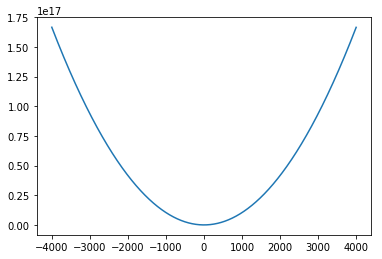

In [1182]:
#This exercise helps us understand the convex nature of the cost function
import numpy as np

mses = []
sqf_coef = range(-4000, 4000)
for coef in sqf_coef:
    pred_values = np.array([coef * TotalSF for TotalSF in training.TotalSF.values])
    mses.append(np.sum((target - pred_values)**2))
    
plt.plot(sqf_coef, mses)
print("Min MSE: {}".format(np.min(mses)))
print("Coeff: {}".format(sqf_coef[np.argmin(mses)]))

In [1183]:
#our cost function is convex! which is good
#our MSE is crazy high, which is not good

In [1184]:
#this is the gradient descent algorithm in code
beta_0 = 0
beta_1 = 0
learning_rate = 0.001
TotalSF_values = training.TotalSF.values
n = len ('TotalSF')
all_mse = []
for _ in range(10000):
    predicted = beta_0 + beta_1 * TotalSF_values
    residuals = target - predicted
    all_mse.append(np.sum(residuals**2))
    beta_0 = beta_0 - learning_rate * ((2/n) * np.sum(residuals) * -1)
    beta_1 = beta_1 - learning_rate * ((2/n) * residuals.dot(TotalSF_values) * -1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


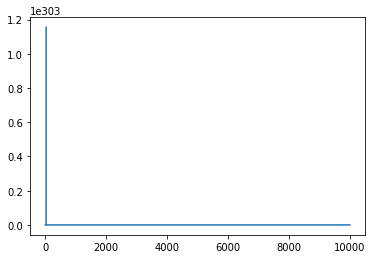

In [1185]:
plt.plot(range(len(all_mse)), all_mse)


This shows that our "step size" may be too big. but still helps me better understand the algorithm

# Linear Regression Model

In [1186]:
#we need to scale and create a dataframe for training
scaler = StandardScaler()
scaler.fit(training)
scaled_df = scaler.transform(training)

In [1187]:
#This creates a simple linear regression model based on our target. 
#tol is our step seze and eta0 tells the model to stop when the gain reaches a certain amount
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(scaled_df, target)
predictions = linear_regression_model.predict(scaled_df)
mse = mean_squared_error(target, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 14.718468942094706


Our first RMSE! This is great progress


We can interpret our linear regression model with some tools shown below

In [1188]:
#this will give us coefficient values
linear_regression_model.fit(scaled_df, target)
sorted(list(zip(training.columns, linear_regression_model.coef_)), key=lambda x: abs(x[1]))

[('Neighborhood_Edwards', -0.0008402461329071493),
 ('Exterior1st_CemntBd', 0.0029264966415693087),
 ('Electrical_FuseP', -0.003537070665855507),
 ('BsmtExposure', 0.0036042147881159914),
 ('BldgType_1Fam', 0.005233023668015873),
 ('GarageYrBlt', -0.005325111873475566),
 ('SaleCondition_AdjLand', -0.0075385363871545005),
 ('Exterior1st_Stucco', 0.008265706008044283),
 ('MasVnrArea', -0.009307856434162062),
 ('LotConfig_Corner', -0.011557935237323217),
 ('Functional', 0.011638204419176039),
 ('Neighborhood_BrkSide', 0.012218863628130813),
 ('GarageType_2Types', -0.013076075925024798),
 ('TotRmsAbvGrd', -0.013918209466644146),
 ('BldgType_Twnhs', -0.014859000875898951),
 ('Condition2_PosN', 0.015135885037931212),
 ('Neighborhood_SawyerW', -0.015965446553041784),
 ('MasVnrType_None', -0.017808446203779867),
 ('LandContour_Bnk', 0.020275982229281894),
 ('Neighborhood_Veenker', 0.020630376557930107),
 ('CentralAir', -0.020733032364723476),
 ('Neighborhood_OldTown', -0.021549885972258657),
 

In [1189]:
#there are a few too many to interpret


Lets work with polynomials now

In [1190]:
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(training)
scaled_poly_df = scaler.fit_transform(poly_df)
print(scaled_poly_df.shape)

(1458, 24530)


In [1191]:
linear_regression_model.fit(scaled_poly_df, target)
predictions = linear_regression_model.predict(scaled_poly_df)
mse = mean_squared_error(target, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 22509663613200.64


ok, good to know, adding polynomial features honestly just freaks out our model, just look at that massive MSE
22 trillion!!!! NOT GOOD

# Lets look at the confdence interval for our model

In [1192]:
n_bootstraps = 1000
bootstrap_X = []
bootstrap_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(scaled_df, target)
    bootstrap_X.append(sample_X)
    bootstrap_y.append(sample_y)

In [1193]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
coeffs = []
for i, data in enumerate(bootstrap_X):
    linear_regression_model.fit(data, bootstrap_y[i])
    coeffs.append(linear_regression_model.coef_)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

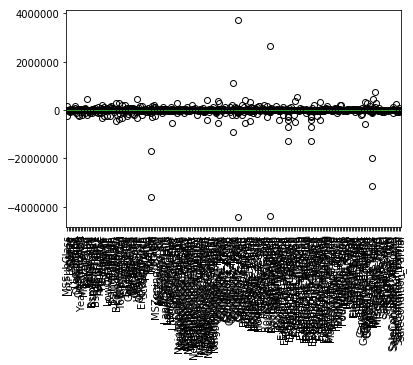

In [1194]:
coef_df = pd.DataFrame(coeffs, columns=training.columns)
coef_df.plot(kind='box')
plt.xticks(rotation=90)

In [1195]:
#I'm worried about some of those large negative coefficients, and the data is too dense to see the effect
#the data is too dense to see confidence intervals

In [1196]:
#this helps me look at the general effect of the coefficient for a specific variable
coef_df['TotalSF'].describe()

count      1000.000000
mean        -96.934402
std        8419.698454
min     -226857.554180
25%          -0.586824
50%          -0.016501
75%           0.406388
max      138979.063408
Name: TotalSF, dtype: float64

# Lets refine the model using a train test split framework

In [1197]:
#this is how to begin the train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

In [1199]:
#here we run the model and control various hyper parameters
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 969.3222338887637
Test MSE: 417.06878917469135


Given the large difference between the train and test MSE, as well as the large MSE we can see we have an a model that is not very accurate, it changes based on randomness. TO help this lets tune the hyper parameters of the model

In [1200]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.003}
Best Negative MSE: -6.412152241147501


This means the best step size for the model is .003 the n iter search means it created buckets in 5 seperate occasions, the cv is the amount of folds we have which was 5. THis negative MSE is great progress for us!


lets see how the linear regression runs with these updated hyperparameters

In [1201]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.003)
linear_regression_model.fit(scaled_df, target)
predictions = linear_regression_model.predict(scaled_df)
mse = mean_squared_error(target, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.10212510730774152


This is our best result yet! LEts try another model to account for the large coefficients

# We have high variance in our model so lets regularize the data to penalize large coefficients

In [1202]:
#let use this regularization model on our train test plit data
from sklearn.linear_model import ElasticNetCV


clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.01219753152594302
Test MSE: 0.014786770548115788


This is by far our best MSE! 
Why?
As we saw on our earlier coefficient visualizer there were a few coefficients with insanely high values, this takes out that overfitting and will allow the model to run in a much smoother way.

LEts run this with the test data a submit our results

# Running the test

In [1203]:
predicted_prices = clf.predict(test)

In [1204]:
print(predicted_prices)

[491.14156621 621.85017716 623.53398636 ... 687.87739024 457.71107301
 627.23358996]


# Printing and submitting results

In [1205]:
my_submission = pd.DataFrame({'Id': test_ID, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [1206]:
my_submission.head(15)

,Id,SalePrice
0,1461,491.141566
1,1462,621.850177
2,1463,623.533986
3,1464,567.069607
4,1465,481.357124
5,1466,541.575407
6,1467,517.147861
7,1468,497.506798
8,1469,567.116666
9,1470,454.696228


My predictions are clearly wrong, I arrived at relatively small MSE but it looks like that is not enough to get even somewhat accurate predicitons. Looking forward to learning how to make better predicitons. Initial thoughts are that I have far too many variables, how can I be more selective?

While I could have found more accurate results by following line for line in kaggle i chose to try to build my own using the tools that I actually understood. 

I submitted to kaggle and recieved a score of 5.73189 and ranked 4045, definitly room to grow
